In [3]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size="6"> Abstract </font>

In this blog post we will be exploring the implementations of the perceptron algorithm and examining a variety of different examples of its uses. We will start by exploring its capability of classifying linearly separable data in 2 dimensions and then we will see how it behaves on not linearly separable and higher dimensional data using single step optimization loops. After that we will implement and use a minibatch optimization loop and compare its results to the single step examples.

I have attached below a link to my source code for the Perceptron class. In the gradient class I implemented conditional statements to check whether we are trying to use a single or minibatch step. Inside each conditional we calculate the score and then check to see how effective our weights are and which predictions were wrong. Then for the wrong scores we multiply against our feature matrix to create the gradient. In the case of a minibatch we then take the average gradient and multiply it by our leaning rate.

<font size="6"> Part A: Implementing Perceptron </font>

The following code imports the necessary libraries and define the functions we will be continually be using throughout this blog post.

In [26]:
#Import Libraries
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
#Set seed for consistent results
torch.manual_seed(1234)

#This function creates our randomized data we are trying to classify
def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

#This function plots our data cleanly
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

X, y = perceptron_data()

#This function plots the weights and decision boundaries
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)



<font size="6"> Part B: Experiments </font>

When our data is linearly separable since the perceptron algorithm converges we can use the weight vector to describe a separating line

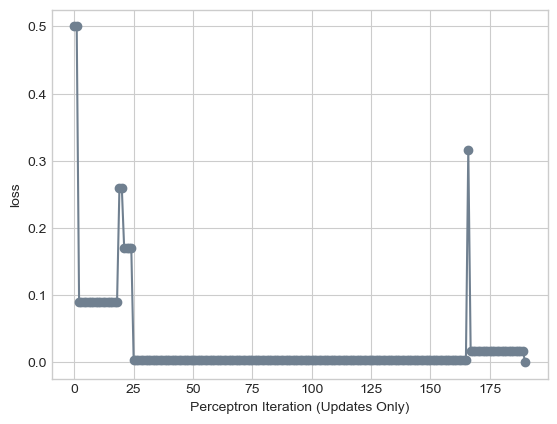

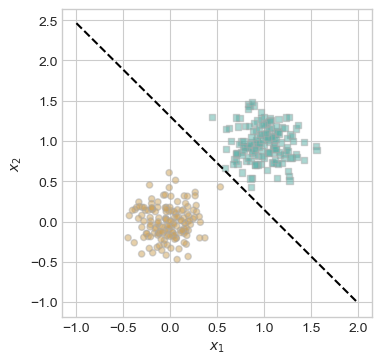

In [27]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    #Take a random x and y pair to optimize on
    i = torch.randint(X.size()[0], size = (1,))
    X_ = X[[i],:]
    y_ = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(X_, y_)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

#Plots the final "optimal" weight vector
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

When using 2 dimensional non-linearly separable data the perceptron algorithm does not settle on a final value of W (the weight vector won't converge), but will instead run until the maximum number of iterations is reached, without ever achieving perfect accuracy.

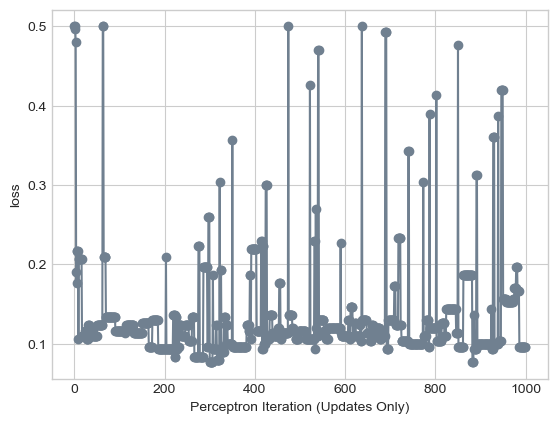

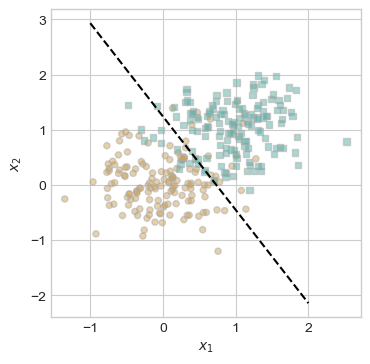

In [85]:
#Initialize not linearly separable data
X, y = perceptron_data(300, .5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while count < 1000 and loss > 0: # Now only goes for 1000 steps or if the loss hits 0 (won't happen)
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    #Take a random x and y pair to optimize on
    i = torch.randint(X.size()[0], size = (1,))
    X_ = X[[i],:]
    y_ = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(X_, y_)

#Plots the progress of our loss through optimization
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

#Plots the final "optimal" weight vector
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")


Our perceptron algorithm is also able to work in more than 2 dimensions! Below is an example of running your algorithm on data with 5 features. You will notice that I have not attached a graph with a decision boundary. This is because it is incredible difficult to graph in 5 dimensions. However, if we just pay attention to the graph of the loss over time, you can see that almost immediately our loss goes down to near 0. From this we can infer that our perceptron algorithm has optimized a nearly accurate  weight vector.

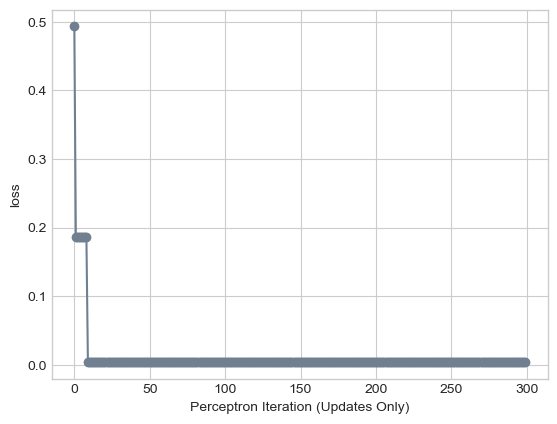

In [66]:
#Initialize 5 dimensional data
X, y = perceptron_data(300, .3, 5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while count < 300 and loss > 0: # Now only goes for 300 steps or if the loss hits 0 (won't happen)
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    i = torch.randint(X.size()[0], size = (1,))

    X_ = X[[i],:]
    y_ = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(X_, y_)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")


<font size="6">  Part C: Minibatch Perceptron </font>

In the following 3 examples we will examine how the optimization performs when, rather than using a singular randomized point to "step", we use a random minibatch of data points.

In this first example we will examine a batch size of k = 1. At this size the minibatch perceptron performs similarly to regular perceptron.

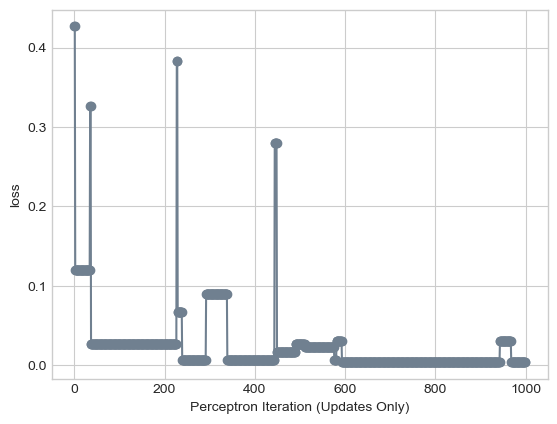

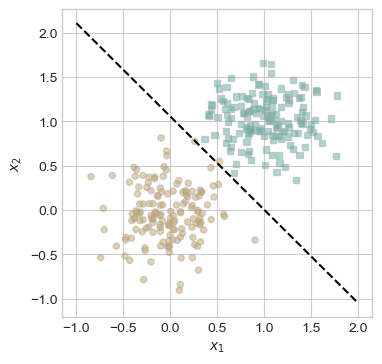

In [86]:
X, y = perceptron_data(300, .3, 2)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while count < 1000 and loss > 0: # dangerous -- only terminates if data is linearly separable
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    #Creates our random minibatch
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    X_ = X[ix,:]
    y_ = y[ix]
    
    # perform a perceptron update using the random data points
    opt.step(X_, y_)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

For our second example we will explore a larger minbatch (when k = 10) and show that the minibatch perceptron can still find a separating line in 2 dimensions

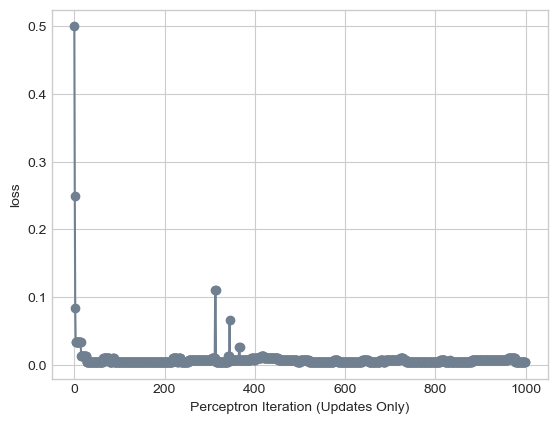

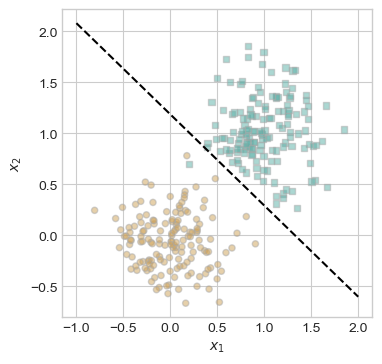

In [88]:
X, y = perceptron_data(300, .3, 2)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while count < 1000 and loss > 0: # dangerous -- only terminates if data is linearly separable
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    #Initialize minibatch of 10 data points
    k = 10
    ix = torch.randperm(X.size(0))[:k]
    X_ = X[ix,:]
    y_ = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(X_, y_)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

For our third and last example we will examine what happens with a minibatch of size k = n (that is, the batch size is the size of the entire data set). We will show that the minibatch perceptron can converge even when the data is not linearly separable, provided that the learning rate is small enough. In order to dictate the learning rate I added an additional optional parameter to our step and gradient functions. By default, this parameter, "alpha", is set to 1. However, for a batch size this large I have set alpha = .01.

You can see that in our loss graph the loss converges to between 10% and 15%

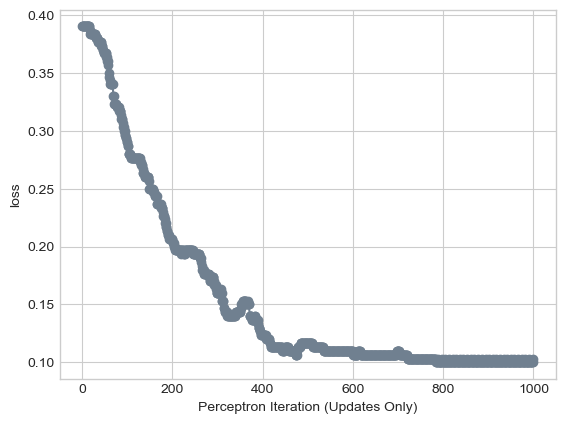

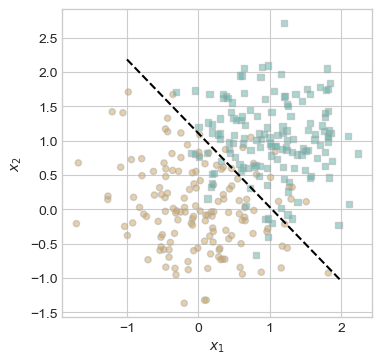

In [95]:
#Initialize not linearly separable data
X, y = perceptron_data(300, .6, 2)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

while count < 1000 and loss > 0: # dangerous -- only terminates if data is linearly separable
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    #takes entire X and y
    ix = torch.randperm(X.size(0))
    X_ = X[ix,:]
    y_ = y[ix]
    
    # perform a perceptron update using the random data points and sets learning rate to .01
    opt.step(X_, y_, .01)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

<font size="6"> Part D: Writing </font>

The runtime of a single iteration of the perceptron algorithm large depends on the time complexity of linear algebraic computations. If X is an NxM matrix and y is Mx1 then the time complexity of X@y is approximately O(2NM), so our score function is O(2NM). Every time we call loss we also call score and get a Nx1 matrix that we multiply through (O(N)), switch to boolean (O(N)), and then we switch back to int and take the mean (O(2N)), so the time complexity of loss is O(2NM) + O(4N). I am going to ignore trying to calculate the time complexity of getting the random data point because the indexing of an array is just O(1) and so it all relies on the complexity of our random function. The last complexity we need to examine is for our step function, which since it contains simple addition and a call to grad we are only concerned with the complexity of grad. If we are looking at a single data point the complexity of grad is O(3M). However, if we are looking at a minibatch of size k, then the complexity is O(2kM + 2k + 2k + 2kM + kM). So, in conclusion a single iteration of the perceptron algorithm is O(2NM + 4N + 3M) = O(NM) for updating at a singular data point and O(2NM + 4N + 5kM + 4k) for a minibatch. The only reason I have kept this in the longer notation is that I wanted to highlight if k < N we will just go O(2NM + 4N + 5kM + 4k) => O(2NM + 4N) => O(2NM) => O(NM) but k = N, then we get O(2NM + 4N + 5NM + 4N) => O(7NM + 8N) => O(7NM) => O(NM). While the final big O is the same as k approaches N our time complexity gets significantly higher.

<font size="6"> Conclusion </font>

We have explored various implementations of the perceptron algorithm seen how their accuracy can/can't be affected my the separability and dimensionality. We know know that given the perceptron works in higher dimension just as well as lower dimensions. The main differentiator is how separable the data is and whether we are using a single step optimizer versus a minibatch optimizer. As our data gets more intertwined we want to start using the minibatch optimizer and a lower learning rate. 